In [69]:
#import libraries
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb
import xgboost as xgb

In [47]:
#Read in data
train = pd.read_csv("C:/Users/Aditya/Downloads/CarsPricePred/train.csv", delimiter = ",")
test = pd.read_csv("C:/Users/Aditya/Downloads/CarsPricePred/test.csv", delimiter = ",")
train.head()



,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [48]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entrie

# Data exploration and visualisation

<AxesSubplot:xlabel='Price', ylabel='Density'>

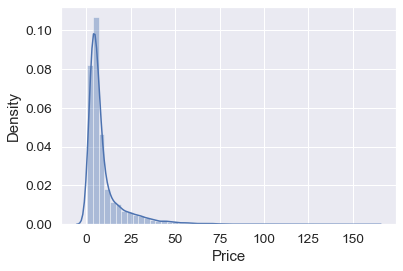

In [70]:
sns.distplot(train['Price'])

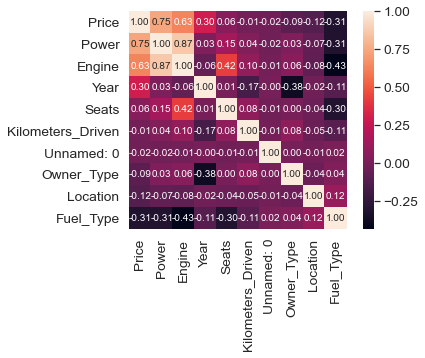

In [67]:
#saleprice correlation matrix
corrmat = train.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Data wrangling
Deleting null entries since majority non-null entries are themselves null entries in different form and converting certain string columns into int since the values mkes sense only in their integer form. Label encoding to convert all columns into int/float for the model to understand the data better.

In [49]:
catfeats_fillnamode = \
    ['Mileage','Engine','Seats']

train.loc[:, catfeats_fillnamode] = \
    train[catfeats_fillnamode].fillna(train[catfeats_fillnamode].mode().iloc[0])

catfeats_fillnamode1 = \
    ['Mileage','Engine','Seats']

test.loc[:, catfeats_fillnamode1] = \
    test[catfeats_fillnamode1].fillna(test[catfeats_fillnamode1].mode().iloc[0])

train = train.drop(train.loc[train['Power'].isnull()].index)
test = test.drop(test.loc[test['Power'].isnull()].index)
train = train[~train.Power.str.startswith('null')]
test = test[~test.Power.str.startswith('null')]
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5876 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5876 non-null   int64  
 1   Name               5876 non-null   object 
 2   Location           5876 non-null   object 
 3   Year               5876 non-null   int64  
 4   Kilometers_Driven  5876 non-null   int64  
 5   Fuel_Type          5876 non-null   object 
 6   Transmission       5876 non-null   object 
 7   Owner_Type         5876 non-null   object 
 8   Mileage            5876 non-null   object 
 9   Engine             5876 non-null   object 
 10  Power              5876 non-null   object 
 11  Seats              5876 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              5876 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 688.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202 entrie

In [50]:
train['Mileage']=train['Mileage'].str.extract('(\d+)').astype(int)
train['Engine']=train['Engine'].str.extract('(\d+)').astype(int)
train['Power']=train['Power'].str.extract('(\d+)').astype(int)

test['Mileage']=test['Mileage'].str.extract('(\d+)').astype(int)
test['Engine']=test['Engine'].str.extract('(\d+)').astype(int)
test['Power']=test['Power'].str.extract('(\d+)').astype(int)

train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26,998,58,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19,1582,126,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18,1199,88,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20,1248,88,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15,1968,140,5.0,NaN,17.74


In [51]:
train=train.drop(["Name","New_Price"],axis=1)
test=test.drop(["Name","New_Price"],axis=1)

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5876 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5876 non-null   int64  
 1   Location           5876 non-null   object 
 2   Year               5876 non-null   int64  
 3   Kilometers_Driven  5876 non-null   int64  
 4   Fuel_Type          5876 non-null   object 
 5   Transmission       5876 non-null   object 
 6   Owner_Type         5876 non-null   object 
 7   Mileage            5876 non-null   int32  
 8   Engine             5876 non-null   int32  
 9   Power              5876 non-null   int32  
 10  Seats              5876 non-null   float64
 11  Price              5876 non-null   float64
dtypes: float64(2), int32(3), int64(3), object(4)
memory usage: 527.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202 entries, 0 to 1233
Data columns (total 11 columns):
 #   Column             Non-Null Count  

In [52]:
s = (train.dtypes == 'object')
r = (test.dtypes == 'object')
object_cols = list(s[s].index)
object_cols = list(r[r].index)
label_encoder = LabelEncoder()
for col in object_cols:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])
    
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5876 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5876 non-null   int64  
 1   Location           5876 non-null   int32  
 2   Year               5876 non-null   int64  
 3   Kilometers_Driven  5876 non-null   int64  
 4   Fuel_Type          5876 non-null   int32  
 5   Transmission       5876 non-null   int32  
 6   Owner_Type         5876 non-null   int32  
 7   Mileage            5876 non-null   int64  
 8   Engine             5876 non-null   int64  
 9   Power              5876 non-null   int64  
 10  Seats              5876 non-null   float64
 11  Price              5876 non-null   float64
dtypes: float64(2), int32(4), int64(6)
memory usage: 505.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202 entries, 0 to 1233
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
--- 

# Building model

In [54]:
X = train.drop(["Unnamed: 0","Price"],axis=1)
Y =  train["Price"] 

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
LR = LinearRegression()
LR.fit(X_train,Y_train)
Pred1 = LR.predict(X_test)
from sklearn.metrics import mean_absolute_error
print("Logistic Regressor's Accuracy: ", mean_squared_error(Y_test, Pred1))


Logistic Regressor's Accuracy:  42.16143983204852


In [61]:
GBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=6, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBR.fit(X_train,Y_train)
Pred = GBR.predict(X_test)
from sklearn.metrics import mean_absolute_error
print("GradientBoostingRegressor's Accuracy: ", mean_squared_error(Y_test, Pred))

GradientBoostingRegressor's Accuracy:  11.658382240689


In [62]:
M2model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
M2model_lgb.fit(X_train,Y_train)
Pred2 = M2model_lgb.predict(X_test)
print("LGBMRegressor's Accuracy: ", mean_squared_error(Y_test, Pred2))

LGBMRegressor's Accuracy:  17.97465992124147


In [63]:
M3model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
M3model_xgb.fit(X_train,Y_train)
Pred3 = M3model_xgb.predict(X_test)
print("XGBRegressor's Accuracy: ", mean_squared_error(Y_test, Pred3))

[11:19:58] WARNING: D:\Build\xgboost\xgboost-1.2.1.git\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBRegressor's Accuracy:  12.890208886865626
